In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.optimizers import SGD
from keras.optimizers import Adam

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import os
from PIL import Image
import csv
print(tf.__version__)
print(tfio.__version__)

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

2.12.0
0.31.0


### Set paths for different data sets

### You will notice that the paths reference File locations where the files are stored as JPGs. I originally started trying to do this using "tf.keras.utils.image_dataset_from_directory" which cannot handle decoding of TIFs and is not well suited for  unsupervised learning projects as you need to have one class for this to work. 

### In this case for the Cancer data we have  2 classes for our data. I opted to leave my converted image files in jpg format for better compatability down the road.

In [44]:
#print(pathlib.Path().absolute())
#print (os.getcwd())
path1 = os.getcwd()

#File_type = '*.tif'
#Train_path = path1 + '\\Week_3_kaggle\\train\\'
#Test_path = path1 + '\\Week_3_kaggle\\train\\' 

File_type = '*.jpg'
Labels_path = path1 + '\\Week_3_kaggle\\'
Train_path = path1 + '\\Week_3_kaggle\\Train_jpg\\'
Test_path = path1 + '\\Week_3_kaggle\\Test_jpg\\'



In [3]:
Labels_File = Labels_path + "train_labels.csv"
Train_Labels = pd.read_csv(Labels_File)
Train_Labels["id"]= Train_Labels["id"] + ".jpg"
Train_Labels['label'] = Train_Labels['label'].astype(str)
result = Train_Labels.head(10)
        
print(result)

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.jpg     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.jpg     1
2  755db6279dae599ebb4d39a9123cce439965282d.jpg     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.jpg     0
4  068aba587a4950175d04c680d38943fd488d6a9d.jpg     0
5  acfe80838488fae3c89bd21ade75be5c34e66be7.jpg     0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.jpg     1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f.jpg     1
8  559e55a64c9ba828f700e948f6886f4cea919261.jpg     0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4.jpg     0


## Import Training data labels for use in our data modeling and data validation
### I found the percentage of cells noted with cancer is fairly high at 40% which gives us a good base to work from and validate our data against it. I think you could do this with less .. maybe around 30%


Percent No Cancer:  59.50 %
Percent Yes Cancer:  40.50 %


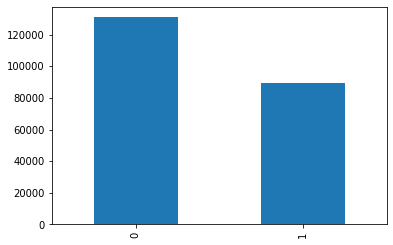

In [62]:
Total_Rows = len(Train_Labels)
No_Cancer_Count = len(Train_Labels[Train_Labels['label']=="0"].value_counts())
Yes_Cancer_Count = len(Train_Labels[Train_Labels['label']=="1"].value_counts())

Percent_No_Cancer = (No_Cancer_Count/Total_Rows) * 100
Percent_Yes_Cancer = (Yes_Cancer_Count/Total_Rows) * 100
print("Percent No Cancer: ",'%.2f' % Percent_No_Cancer,"%")
print("Percent Yes Cancer: ",'%.2f' % Percent_Yes_Cancer, "%")

Train_Labels['label'].value_counts().plot(kind='bar')

plt.show()

## Setting up the model

### I am new to trying to design a neural network with CNN and found several different methods online with which to implement this with one technique of "transfer learning" to help achieve better results showing up in several articles, but decided to keep this as simple as possible least I make a mistake in applying something I don't fully understand and has not been reviewed in this class.

### I found out quite quickly that several combinations with respect to Batch size  and Image shape size affect the accuracy and loss results, as well as the total run time to complete building the Model. I eventually settled in on a batch size of 512 and shape input of 32x32. This combination seemed to give the best balance from a speed and result perspective with my basic layer configration.

### I did run tests using the sigmoid function only but did not find that it improved the accuracy much and ended up sticking with relu for my intial layers and applying sigmoid on the final layer which performed well with a binary class like this.



In [94]:
CNN_Model1 = Sequential()

fig_size = 32
activation_value1 = 'relu'
activation_value2 = 'sigmoid'
activation_value3 = 'softmax'

CNN_Model1.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation_value1))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))

CNN_Model1.add(Conv2D(filters=16, kernel_size=(3,3), activation=activation_value1))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))

CNN_Model1.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation_value1))
CNN_Model1.add(MaxPool2D(pool_size=(2,2)))

CNN_Model1.add(Flatten())
CNN_Model1.add(Dense(units=1, activation=activation_value2))

batch_size = 512
CNN_Model1.build(input_shape=(batch_size, fig_size, fig_size, 3))
CNN_Model1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (512, 30, 30, 64)         1792      
                                                                 
 max_pooling2d_52 (MaxPoolin  (512, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (512, 13, 13, 16)         9232      
                                                                 
 max_pooling2d_53 (MaxPoolin  (512, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (512, 4, 4, 32)           4640      
                                                                 
 max_pooling2d_54 (MaxPoolin  (512, 2, 2, 32)        

## Implementing the training and validation data setup

### Important parameters here are shuffle, class_mode, batch_size and target_size:                                                      Most of these are pretty standard from a parameter perspective, but I did end up adding the shuffle parameter after running multiple test where I thought I should have been getting different results but they seemed to stagnate somewhat with respect to the range for the accuracy and loss. 

### Adding this helped alleviate this problem where the basic idea is to shuffle the data being input to avoid any innate bias in the ordering of the data.

### One other change I made was in shifting  the validation split to from 0.20 to 0.30, thus allowing for more data for validation purposes

In [95]:
generator = ImageDataGenerator(rescale=1./255, validation_split=0.30)

data_train = generator.flow_from_dataframe(
    dataframe = Train_Labels,
    shuffle=True,
    x_col='id', # filenames
    y_col='label', # labels
    directory=Train_path,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(fig_size, fig_size))

data_validate=generator.flow_from_dataframe(
    dataframe=Train_Labels,
    shuffle=True,
    x_col='id', # filenames
    y_col='label', # labels
    directory=Train_path,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=(fig_size, fig_size))

Found 154018 validated image filenames belonging to 2 classes.
Found 66007 validated image filenames belonging to 2 classes.


## Running and Building the model history dataset

### One of the intial tests I did here was to compare optimizing methods to see how well the accuracy and loss values would compare with different optimizers. We had gone over SGD but it did not fit well with this model and performance below par. Most common with this type of dataset was the use of an Adam optimizer and I stuck with that for the remainder of my tests.

### A last minute changes I made was to the Loss parameter and included the from_logits clause and set it equal to true. This is needed addition when using  sigmoid function on the last layer of your model.

### Epochs: I found this pretty effective at 3 and 5 with testing my results and it  allowed me to make a determination with respect to any changes I made fairly quickly. 

### After running those quicker tests, I set the epoch counter higher to test and see if more would be better or not and check for overfitting with the model. I start with 15 Epochs, down to 10 and the 5 as the final run.

In [96]:

#Optimizer1 = SGD(name= "SGD", learning_rate = 0.0001, nesterov = False, momentum = 0.0)
Optimizer1 = Adam(learning_rate=0.001)

epoch_count = 15
CNN_Model1.compile(optimizer=Optimizer1, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
#CNN_Model1.compile(optimizer=Optimizer1, loss='binary_crossentropy', metrics=['accuracy'])
CNN_Final = CNN_Model1.fit(data_train, validation_data=data_validate, epochs=epoch_count)

Epoch 1/15


C:\Users\Rivendell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


301/301 [==============================] - 177s 587ms/step - loss: 0.5019 - accuracy: 0.7592 - val_loss: 0.4656 - val_accuracy: 0.7884
Epoch 2/15
301/301 [==============================] - 173s 575ms/step - loss: 0.4658 - accuracy: 0.7854 - val_loss: 0.4509 - val_accuracy: 0.7937
Epoch 3/15
301/301 [==============================] - 173s 576ms/step - loss: 0.4509 - accuracy: 0.7937 - val_loss: 0.4376 - val_accuracy: 0.8020
Epoch 4/15
301/301 [==============================] - 172s 571ms/step - loss: 0.4358 - accuracy: 0.8026 - val_loss: 0.4242 - val_accuracy: 0.8080
Epoch 5/15
301/301 [==============================] - 175s 580ms/step - loss: 0.4233 - accuracy: 0.8109 - val_loss: 0.4063 - val_accuracy: 0.8182
Epoch 6/15
301/301 [==============================] - 171s 570ms/step - loss: 0.4061 - accuracy: 0.8207 - val_loss: 0.3957 - val_accuracy: 0.8264
Epoch 7/15
301/301 [==============================] - 173s 574ms/step - loss: 0.4023 - accuracy: 0.8218 - val_loss: 0.3864 - val_accura

## Overfitting for Loss and Accuracy charts as they eventually change positions on the charts

### Plot Train and Validation Loss Results

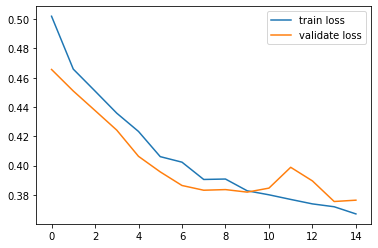

<Figure size 432x288 with 0 Axes>

In [97]:
plt.plot(CNN_Final.history['loss'], label='train loss')
plt.plot(CNN_Final.history['val_loss'], label='validate loss')
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')

### Plot Train and Validation Accuracy Results

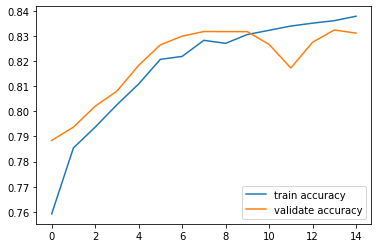

<Figure size 432x288 with 0 Axes>

In [98]:
plt.plot(CNN_Final.history['accuracy'], label='train accuracy')
plt.plot(CNN_Final.history['val_accuracy'], label='validate accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

## Second Model with 10 Epochs based on previous charting cross point around 9-10

In [109]:
CNN_Model2 = Sequential()

fig_size = 32
activation_value1 = 'relu'
activation_value2 = 'sigmoid'
activation_value3 = 'softmax'

CNN_Model2.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation_value1))
CNN_Model2.add(MaxPool2D(pool_size=(2,2)))

CNN_Model2.add(Conv2D(filters=16, kernel_size=(3,3), activation=activation_value1))
CNN_Model2.add(MaxPool2D(pool_size=(2,2)))

CNN_Model2.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation_value1))
CNN_Model2.add(MaxPool2D(pool_size=(2,2)))

CNN_Model2.add(Flatten())
CNN_Model2.add(Dense(units=1, activation=activation_value2))

batch_size = 512
CNN_Model2.build(input_shape=(batch_size, fig_size, fig_size, 3))
CNN_Model2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (512, 30, 30, 64)         1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  (512, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (512, 13, 13, 16)         9232      
                                                                 
 max_pooling2d_56 (MaxPoolin  (512, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (512, 4, 4, 32)           4640      
                                                                 
 max_pooling2d_57 (MaxPoolin  (512, 2, 2, 32)        

In [110]:

#Optimizer1 = SGD(name= "SGD", learning_rate = 0.0001, nesterov = False, momentum = 0.0)
Optimizer1 = Adam(learning_rate=0.001)

epoch_count = 10
CNN_Model2.compile(optimizer=Optimizer1, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
CNN_Final2 = CNN_Model2.fit(data_train, validation_data=data_validate, epochs=epoch_count)

Epoch 1/10


C:\Users\Rivendell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


301/301 [==============================] - 173s 574ms/step - loss: 0.5046 - accuracy: 0.7537 - val_loss: 0.4748 - val_accuracy: 0.7782
Epoch 2/10
301/301 [==============================] - 169s 562ms/step - loss: 0.4614 - accuracy: 0.7886 - val_loss: 0.4682 - val_accuracy: 0.7806
Epoch 3/10
301/301 [==============================] - 169s 563ms/step - loss: 0.4456 - accuracy: 0.7974 - val_loss: 0.4319 - val_accuracy: 0.8050
Epoch 4/10
301/301 [==============================] - 170s 566ms/step - loss: 0.4351 - accuracy: 0.8027 - val_loss: 0.4193 - val_accuracy: 0.8154
Epoch 5/10
301/301 [==============================] - 171s 569ms/step - loss: 0.4205 - accuracy: 0.8128 - val_loss: 0.4111 - val_accuracy: 0.8196
Epoch 6/10
301/301 [==============================] - 170s 564ms/step - loss: 0.4133 - accuracy: 0.8163 - val_loss: 0.4100 - val_accuracy: 0.8186
Epoch 7/10
301/301 [==============================] - 168s 557ms/step - loss: 0.4057 - accuracy: 0.8209 - val_loss: 0.4163 - val_accura

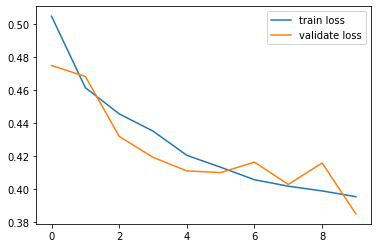

<Figure size 432x288 with 0 Axes>

In [111]:
plt.plot(CNN_Final2.history['loss'], label='train loss')
plt.plot(CNN_Final2.history['val_loss'], label='validate loss')
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')

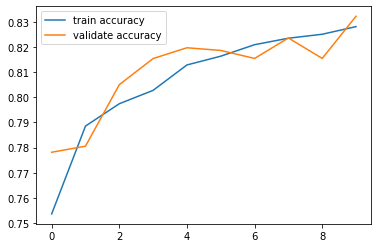

<Figure size 432x288 with 0 Axes>

In [112]:
plt.plot(CNN_Final2.history['accuracy'], label='train accuracy')
plt.plot(CNN_Final2.history['val_accuracy'], label='validate accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

## Third Model using only 5 Epochs. This seems to avoid overfitting at this epoch count

In [118]:
CNN_Model3 = Sequential()

fig_size = 32
activation_value1 = 'relu'
activation_value2 = 'sigmoid'
activation_value3 = 'softmax'

CNN_Model3.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation_value1))
CNN_Model3.add(MaxPool2D(pool_size=(2,2)))

CNN_Model3.add(Conv2D(filters=16, kernel_size=(3,3), activation=activation_value1))
CNN_Model3.add(MaxPool2D(pool_size=(2,2)))

CNN_Model3.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation_value1))
CNN_Model3.add(MaxPool2D(pool_size=(2,2)))

CNN_Model3.add(Flatten())
CNN_Model3.add(Dense(units=1, activation=activation_value2))

batch_size = 512
CNN_Model3.build(input_shape=(batch_size, fig_size, fig_size, 3))
CNN_Model3.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (512, 30, 30, 64)         1792      
                                                                 
 max_pooling2d_61 (MaxPoolin  (512, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (512, 13, 13, 16)         9232      
                                                                 
 max_pooling2d_62 (MaxPoolin  (512, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (512, 4, 4, 32)           4640      
                                                                 
 max_pooling2d_63 (MaxPoolin  (512, 2, 2, 32)        

In [119]:

Optimizer1 = Adam(learning_rate=0.001)

epoch_count = 5
CNN_Model3.compile(optimizer=Optimizer1, loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])
CNN_Final3 = CNN_Model3.fit(data_train, validation_data=data_validate, epochs=epoch_count)

Epoch 1/5
301/301 [==============================] - 181s 600ms/step - loss: 0.5074 - accuracy: 0.7550 - val_loss: 0.4701 - val_accuracy: 0.7863
Epoch 2/5
301/301 [==============================] - 170s 566ms/step - loss: 0.4690 - accuracy: 0.7852 - val_loss: 0.4563 - val_accuracy: 0.7913
Epoch 3/5
301/301 [==============================] - 171s 569ms/step - loss: 0.4531 - accuracy: 0.7936 - val_loss: 0.4426 - val_accuracy: 0.7997
Epoch 4/5
301/301 [==============================] - 182s 603ms/step - loss: 0.4484 - accuracy: 0.7951 - val_loss: 0.4478 - val_accuracy: 0.7987
Epoch 5/5
301/301 [==============================] - 170s 565ms/step - loss: 0.4346 - accuracy: 0.8028 - val_loss: 0.4279 - val_accuracy: 0.8097


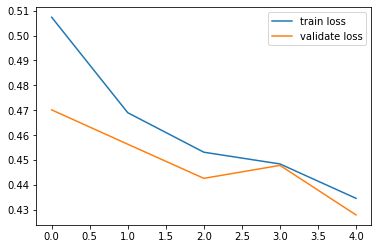

<Figure size 432x288 with 0 Axes>

In [120]:
plt.plot(CNN_Final3.history['loss'], label='train loss')
plt.plot(CNN_Final3.history['val_loss'], label='validate loss')
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')

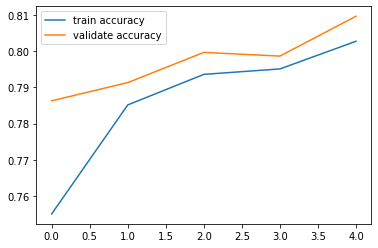

<Figure size 432x288 with 0 Axes>

In [121]:
plt.plot(CNN_Final3.history['accuracy'], label='train accuracy')
plt.plot(CNN_Final3.history['val_accuracy'], label='validate accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

## Run Predictions against Test images

In [122]:
Test_Image_Names = pd.DataFrame({'id':os.listdir(Test_path)})

generator_test = ImageDataGenerator(rescale=1./255)

Test_Data = generator_test.flow_from_dataframe(
    dataframe = Test_Image_Names,
    x_col='id', # filenames
    directory=Test_path,
    class_mode=None,
    batch_size=1,
    target_size=(fig_size, fig_size),
    shuffle=False)

Found 57458 validated image filenames.


In [123]:
cnn_predict = CNN_Model2.predict(Test_Data, verbose=1)

57458/57458 [==============================] - 121s 2ms/step


## Export Prediction results to file for Kaggle Submission

### My final public score was 0.8991, which was pretty good for my basic approach to this neural net and not introducing and other methods such as transfer learning. This was done with only 5 epochs as more than that lead to overfitting

In [124]:

CNN_Cancer_File = pd.DataFrame()
CNN_Cancer_File['id'] = Test_Image_Names['id'].apply(lambda x: x.split('.')[0])
CNN_Cancer_File['label'] = cnn_predict[:, 0]

print(CNN_Cancer_File.head())

CNN_Cancer_File['label'].value_counts()
CNN_Cancer_File.to_csv('CNN_Cancer_File_5_Epochs.csv', index=False)

                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.763957
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.769138
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.389096
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.081081
4  000270442cc15af719583a8172c87cd2bd9c7746  0.069021
